<center><h1>Fernandes_Alrik_HW4</h1></center>
<br>
<br>

Name: Alrik Melville Fernandes
<br>
Github Username: AlrikF
<br>
USC ID: 4036859519

### Utilizing one late day token

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [ ]:

import os
import pandas as pd
import numpy as np
from sklearn.utils import resample
from detect_delimiter import detect
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn import metrics
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

Get the AReM Data Set

In [31]:
rootdir= '.././data/AReM'

### (b) Splitting Data

In [32]:
train_files =[]
test_files  =[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        folder=subdir.split('\\')
        if len(folder)<2:
            continue
        folder=folder[1]
        if folder in ['bending1','bending2']:
            if file in ['dataset1.csv','dataset2.csv']:
                test_files.append('/'.join([folder,file]))
            else:
                train_files.append('/'.join([folder,file]))
        else:
            if file in ['dataset1.csv','dataset2.csv','dataset3.csv']:
                test_files.append('/'.join([folder,file]))
            else:
                train_files.append('/'.join([folder,file]))
                            


### (c) Feature Extraction

In [33]:
def read_and_transform_dataset(file_list, divide):
    headings=["Min","Max","Mean","Median","standard deviation", "first quartile", "third quartile"]
    header=[]

    for i in range(1,6*divide+1):
        for head in headings:
            header.append(head+f"_{i}")
    header.append("class")
    
    final_df=pd.DataFrame([],columns=header)
    ind=0
    for file in file_list:
        f = open(rootdir+"/"+file, "r")
        delim = detect([next(f) for _ in range(10)][6])
        df=pd.read_csv(rootdir+"/"+file,  skiprows=5, header=None, sep=delim , on_bad_lines='skip', \
                                     names=['time_x','avg_rss12_x','var_rss12_x','avg_rss13_x','var_rss13_x','avg_rss23_x','var_rss23_x'] )
        
        if delim != ',':
            df=pd.read_csv(rootdir+"/"+file,  skiprows=5, header=None , delimiter = '\s+',  \
                                     names=['time_x','avg_rss12_x','var_rss12_x','avg_rss13_x','var_rss13_x','avg_rss23_x','var_rss23_x'] )
        
        div= len(df)//divide
        split_df=[]
        for i in range(divide):
            splt = df.iloc[i*div :i*div+div,1:].reset_index(drop=True)
            splt.columns = splt.columns.str.replace('x',f'{i}')
            split_df.append(splt)
        df= pd.concat(split_df,axis=1)
        
        row=[]
        for col in df.columns:
            row.append(df[col].min())
            row.append(df[col].max()) 
            row.append(df[col].mean())
            row.append(df[col].median())
            row.append(df[col].std())
            row.append(df[col].quantile(0.25))
            row.append(df[col].quantile(0.75))
        row.append(file.split("/")[0])
        final_df.loc[ind]=row
        ind+=1
    
    return final_df

In [34]:
train=read_and_transform_dataset(train_files,1)
train

Min_1  Max_1     Mean_1  Median_1  standard deviation_1  first quartile_1  \
0   35.00  47.40  43.954500    44.330              1.558835             43.00   
1   33.00  47.75  42.179812    43.500              3.670666             39.15   
2   33.00  45.75  41.678063    41.750              2.243490             41.33   
3   37.00  48.00  43.454958    43.250              1.386098             42.50   
4   36.25  48.00  43.969125    44.500              1.618364             43.31   
..    ...    ...        ...       ...                   ...               ...   
64  20.75  46.25  34.763333    35.290              4.742208             31.67   
65  21.50  51.00  34.935812    35.500              4.645944             32.00   
66  18.33  47.67  34.333042    34.750              4.948770             31.25   
67  18.33  45.75  34.599875    35.125              4.731790             31.50   
68  15.50  43.67  34.225875    34.750              4.441798             31.25   

    third quartile_1  Min_2  Max_2    Mean_2  ...  first quartile_5  \
0            45.0000    0.0   1.70  0.426250  ...           35.3625   
1            45.0000    0.0   3.00  0.696042  ...           30.4575   
2            42.7500    0.0   2.83  0.535979  ...           28.4575   
3            45.0000    0.0   1.58  0.378083  ...           22.2500   
4            44.6700    0.0   1.50  0.413125  ...           20.5000   
..               ...    ...    ...       ...  ...               ...   
64           38.2500    0.0  12.68  4.223792  ...           14.2500   
65           38.0625    0.0  12.21  4.115750  ...           14.2375   
66           38.0000    0.0  12.48  4.396958  ...           13.7500   
67           38.0000    0.0  15.37  4.398833  ...           14.0000   
68           37.2500    0.0  17.24  4.354500  ...           14.3300   

    third quartile_5  Min_6  Max_6    Mean_6  Median_6  standard deviation_6  \
0              36.50    0.0   1.79  0.493292     0.430              0.513506   
1              36.33    0.0   2.18  0.613521     0.500              0.524317   
2              31.25    0.0   1.79  0.383292     0.430              0.389164   
3              24.00    0.0   5.26  0.679646     0.500              0.622534   
4              23.75    0.0   2.96  0.555312     0.490              0.487826   
..               ...    ...    ...       ...       ...                   ...   
64             18.33    0.0   9.39  3.288271     3.270              1.647528   
65             18.25    0.0  10.21  3.280021     3.015              1.700918   
66             18.00    0.0   8.01  3.261583     2.980              1.617290   
67             18.25    0.0   8.86  3.289542     3.015              1.680170   
68             18.25    0.0   9.42  3.479542     3.270              1.761146   

    first quartile_6  third quartile_6     class  
0               0.00            0.9400  bending1  
1               0.00            1.0000  bending1  
2               0.00            0.5000  bending1  
3               0.43            0.8700  bending1  
4               0.00            0.8300  bending1  
..               ...               ...       ...  
64              2.05            4.3050   walking  
65              2.12            4.5000   walking  
66              2.05            4.3200   walking  
67              2.12            4.2600   walking  
68              2.24            4.5375   walking  

[69 rows x 43 columns]

In [35]:
test = read_and_transform_dataset(test_files,1)
test

Min_1  Max_1     Mean_1  Median_1  standard deviation_1  first quartile_1  \
0   37.25  45.00  40.624792    40.500              1.476967           39.2500   
1   38.00  45.67  42.812812    42.500              1.435550           42.0000   
2   12.75  51.00  24.562958    24.250              3.737514           23.1875   
3    0.00  42.75  27.464604    28.000              3.583582           25.5000   
4   24.25  45.00  37.177042    36.250              3.581301           34.5000   
5   28.75  44.75  37.561187    36.875              3.226507           35.2500   
6   22.00  44.67  37.058708    36.000              3.710180           34.5000   
7   23.50  30.00  27.716375    27.500              1.442253           27.0000   
8   24.75  48.33  44.182937    48.000              7.495615           48.0000   
9   48.00  48.25  48.004167    48.000              0.032038           48.0000   
10  33.25  48.00  42.363563    43.000              2.068247           42.0000   
11  37.00  50.75  45.917667    45.635              1.089027           45.0000   
12  44.50  46.75  45.239667    45.000              0.429915           45.0000   
13  33.33  48.00  44.334729    45.000              2.476940           42.2500   
14  35.50  46.25  43.174938    43.670              1.989052           42.5000   
15  32.75  47.00  42.760562    44.500              3.398919           41.3300   
16  19.33  43.50  34.227771    35.500              4.889576           30.5000   
17  12.50  45.00  33.509729    34.125              4.850923           30.5000   
18  15.00  46.75  34.660583    35.000              5.315110           31.0000   

    third quartile_1  Min_2  Max_2    Mean_2  ...  first quartile_5  \
0            42.0000    0.0   1.30  0.358604  ...           33.0000   
1            43.6700    0.0   1.22  0.372437  ...           32.0000   
2            26.5000    0.0   6.87  0.590833  ...           20.5000   
3            30.0000    0.0   7.76  0.449708  ...           15.0000   
4            40.2500    0.0   8.58  2.374208  ...           17.9500   
5            40.2500    0.0   9.91  2.080687  ...           18.0000   
6            40.0625    0.0  14.17  2.438146  ...           16.0000   
7            29.0000    0.0   1.79  0.363687  ...            5.5000   
8            48.0000    0.0   3.11  0.101875  ...            2.0000   
9            48.0000    0.0   0.43  0.007167  ...            4.6700   
10           43.5000    0.0   4.44  0.492563  ...           10.1875   
11           46.5000    0.0   4.87  0.324542  ...           16.5000   
12           45.3300    0.0   1.00  0.172958  ...           17.6275   
13           46.5000    0.0   3.90  0.432958  ...            9.3300   
14           44.5000    0.0   2.12  0.506583  ...           12.7500   
15           45.3725    0.0   3.34  0.486167  ...           13.0000   
16           37.7500    0.0  14.50  3.995729  ...           14.7500   
17           36.7500    0.0  13.05  4.450771  ...           14.6275   
18           38.2500    0.0  13.44  4.200896  ...           14.2500   

    third quartile_5  Min_6  Max_6    Mean_6  Median_6  standard deviation_6  \
0            36.0000    0.0   1.92  0.570583     0.430              0.582915   
1            34.5000    0.0   3.11  0.571083     0.430              0.601010   
2            27.0000    0.0   4.97  0.700188     0.500              0.693720   
3            20.7500    0.0   6.76  1.122125     0.830              1.012342   
4            21.7500    0.0   9.34  2.921729     2.500              1.852600   
5            21.5000    0.0   9.62  2.765896     2.450              1.769203   
6            21.0000    0.0   8.55  2.983750     2.570              1.815730   
7            10.7500    0.0   4.50  0.734271     0.710              0.613688   
8             5.5425    0.0   3.91  0.692771     0.500              0.675781   
9            10.0000    0.0   2.50  0.641229     0.500              0.388372   
10           17.6900    0.0   6.02  1.034021     0.830              0.985627   
11

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

In [36]:
def break_and_pairplot(train, sel_features, sel_time_series,total_time_series):
    ncols=len(train.columns)//total_time_series
    df_pairplot = pd.concat([train.iloc[:,x*ncols:x*ncols+ncols][[f"{feat}_{x+1}" for feat in  sel_features  ]]  for x in sel_time_series],axis=1)
    df_pairplot["class"]= train["class"].apply(lambda x: np.where('bending' in x , 'bending' ,'not bending' ))
  
    sns.pairplot(df_pairplot,hue='class' )
    plt.show()

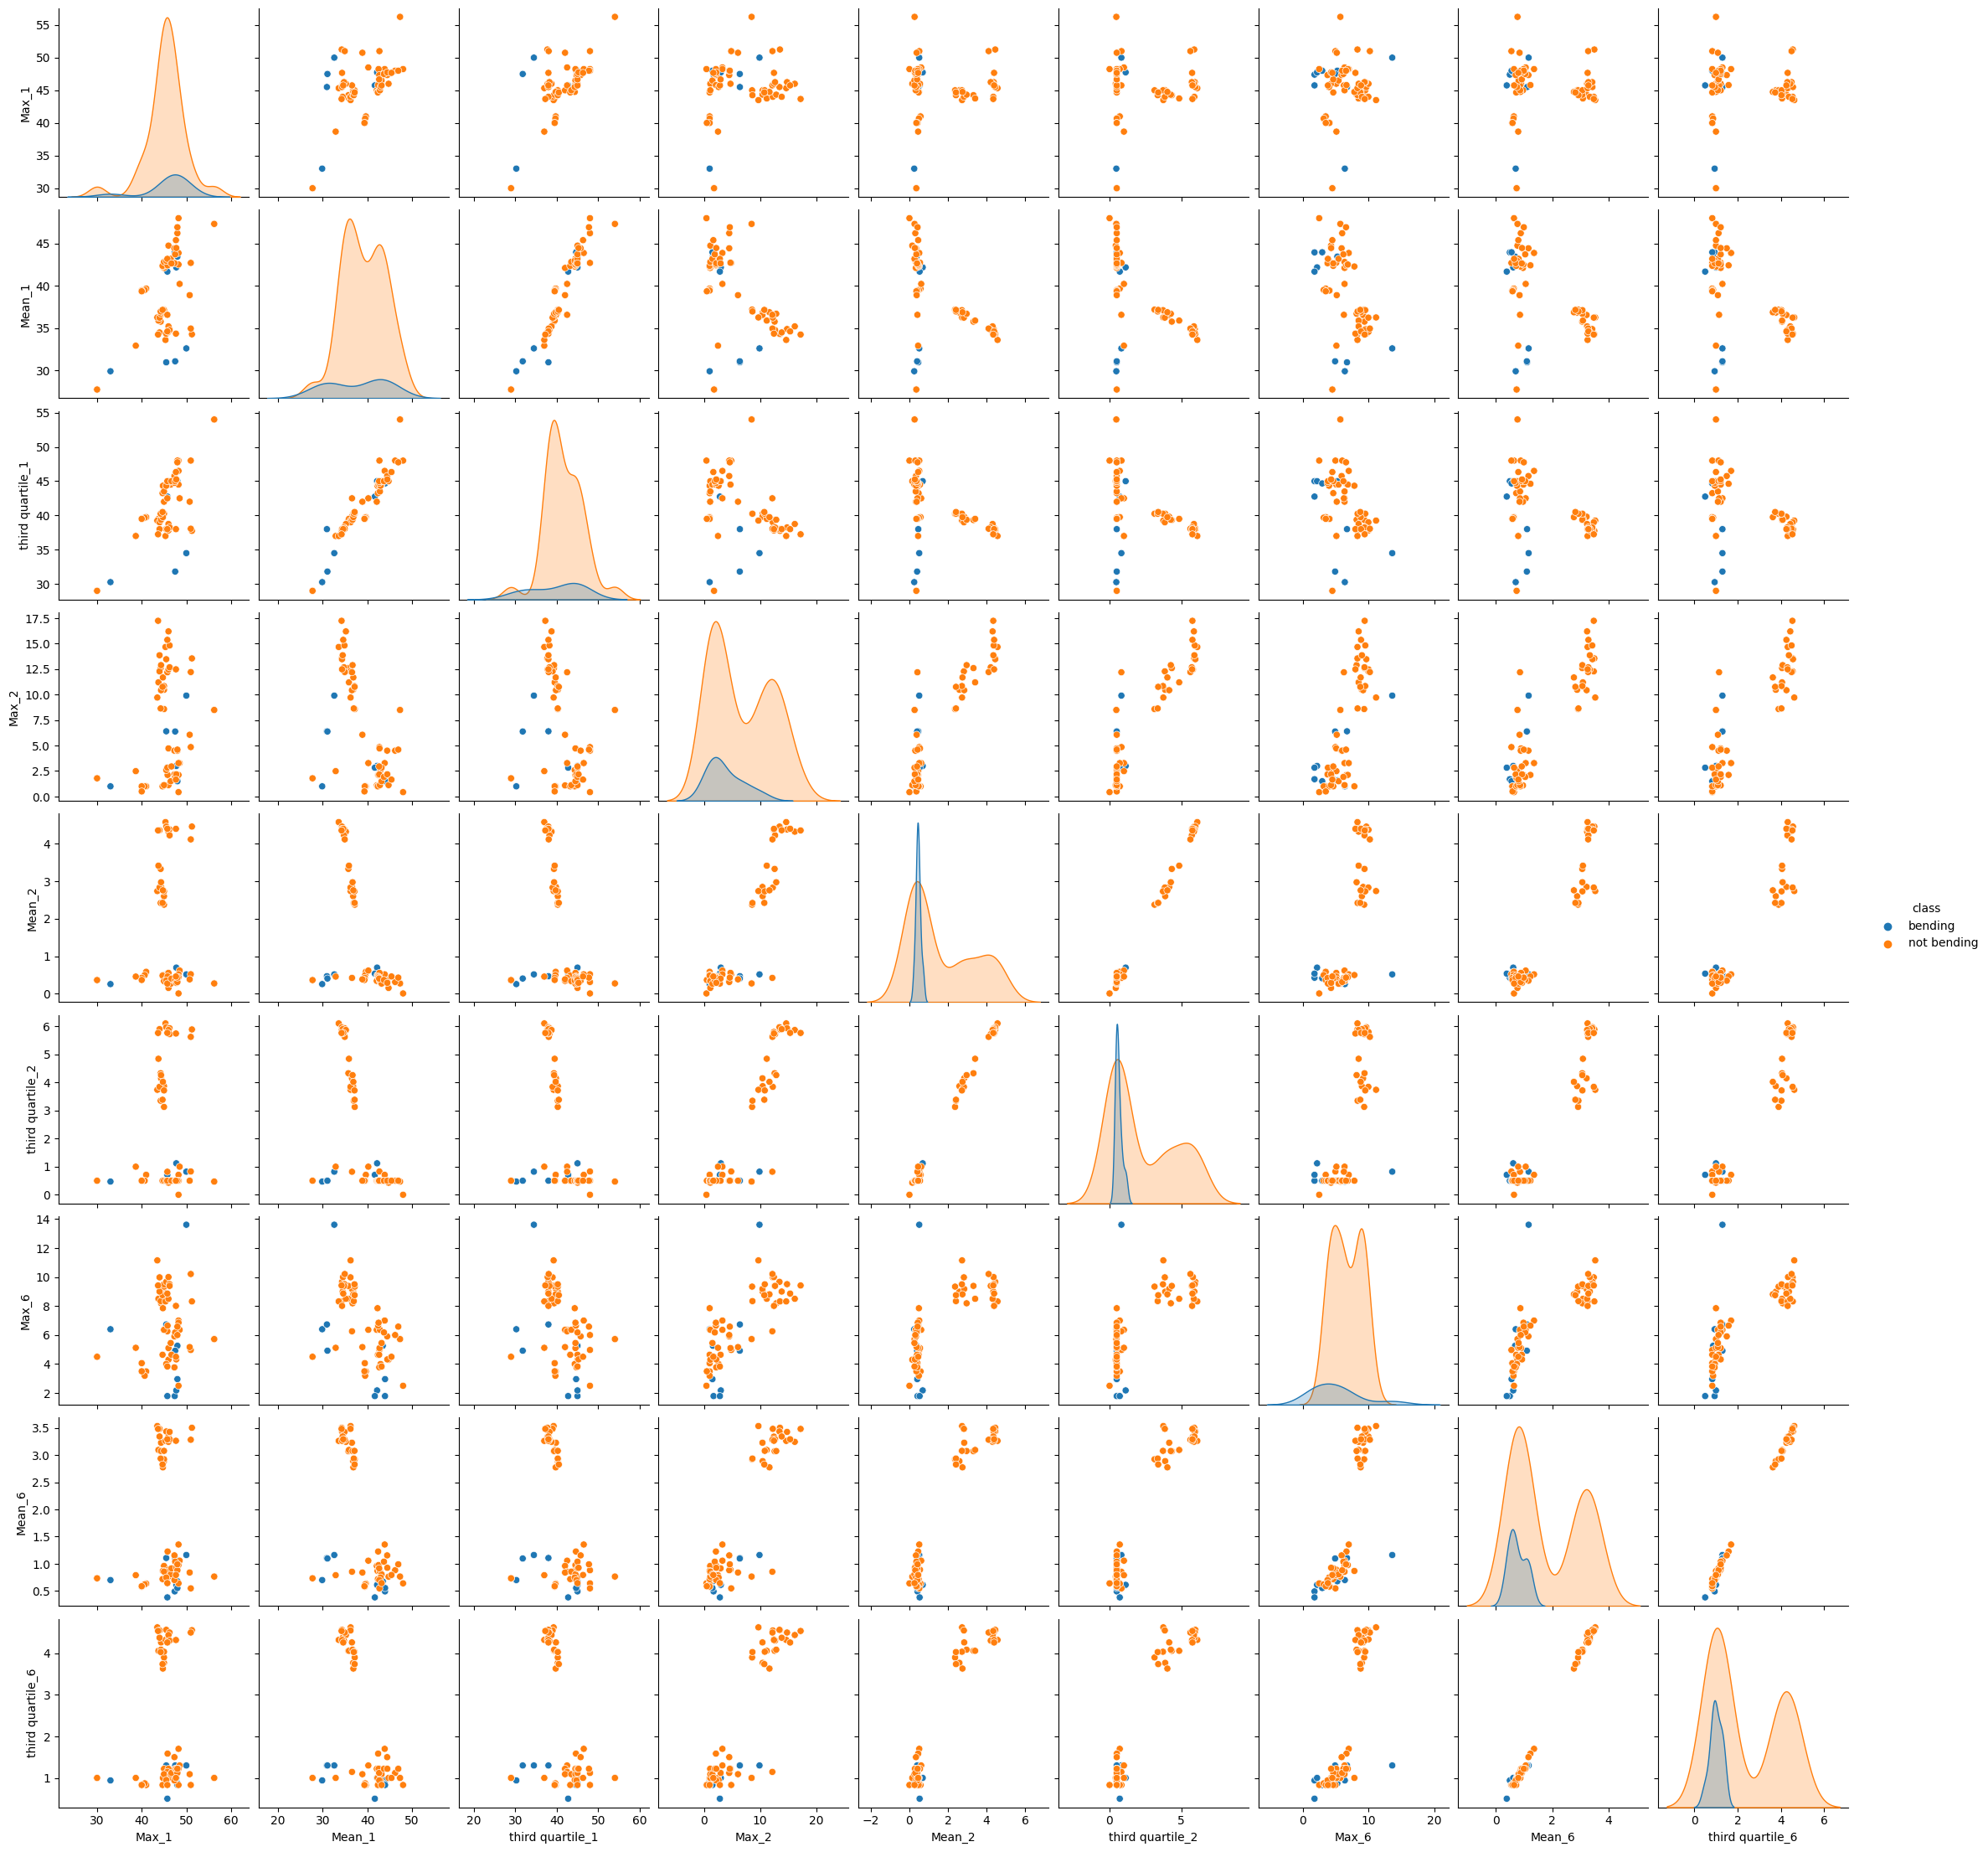

In [37]:
break_and_pairplot(train, ["Max","Mean","third quartile"],[0,1,5],6)

#### ii. Splitted Plots

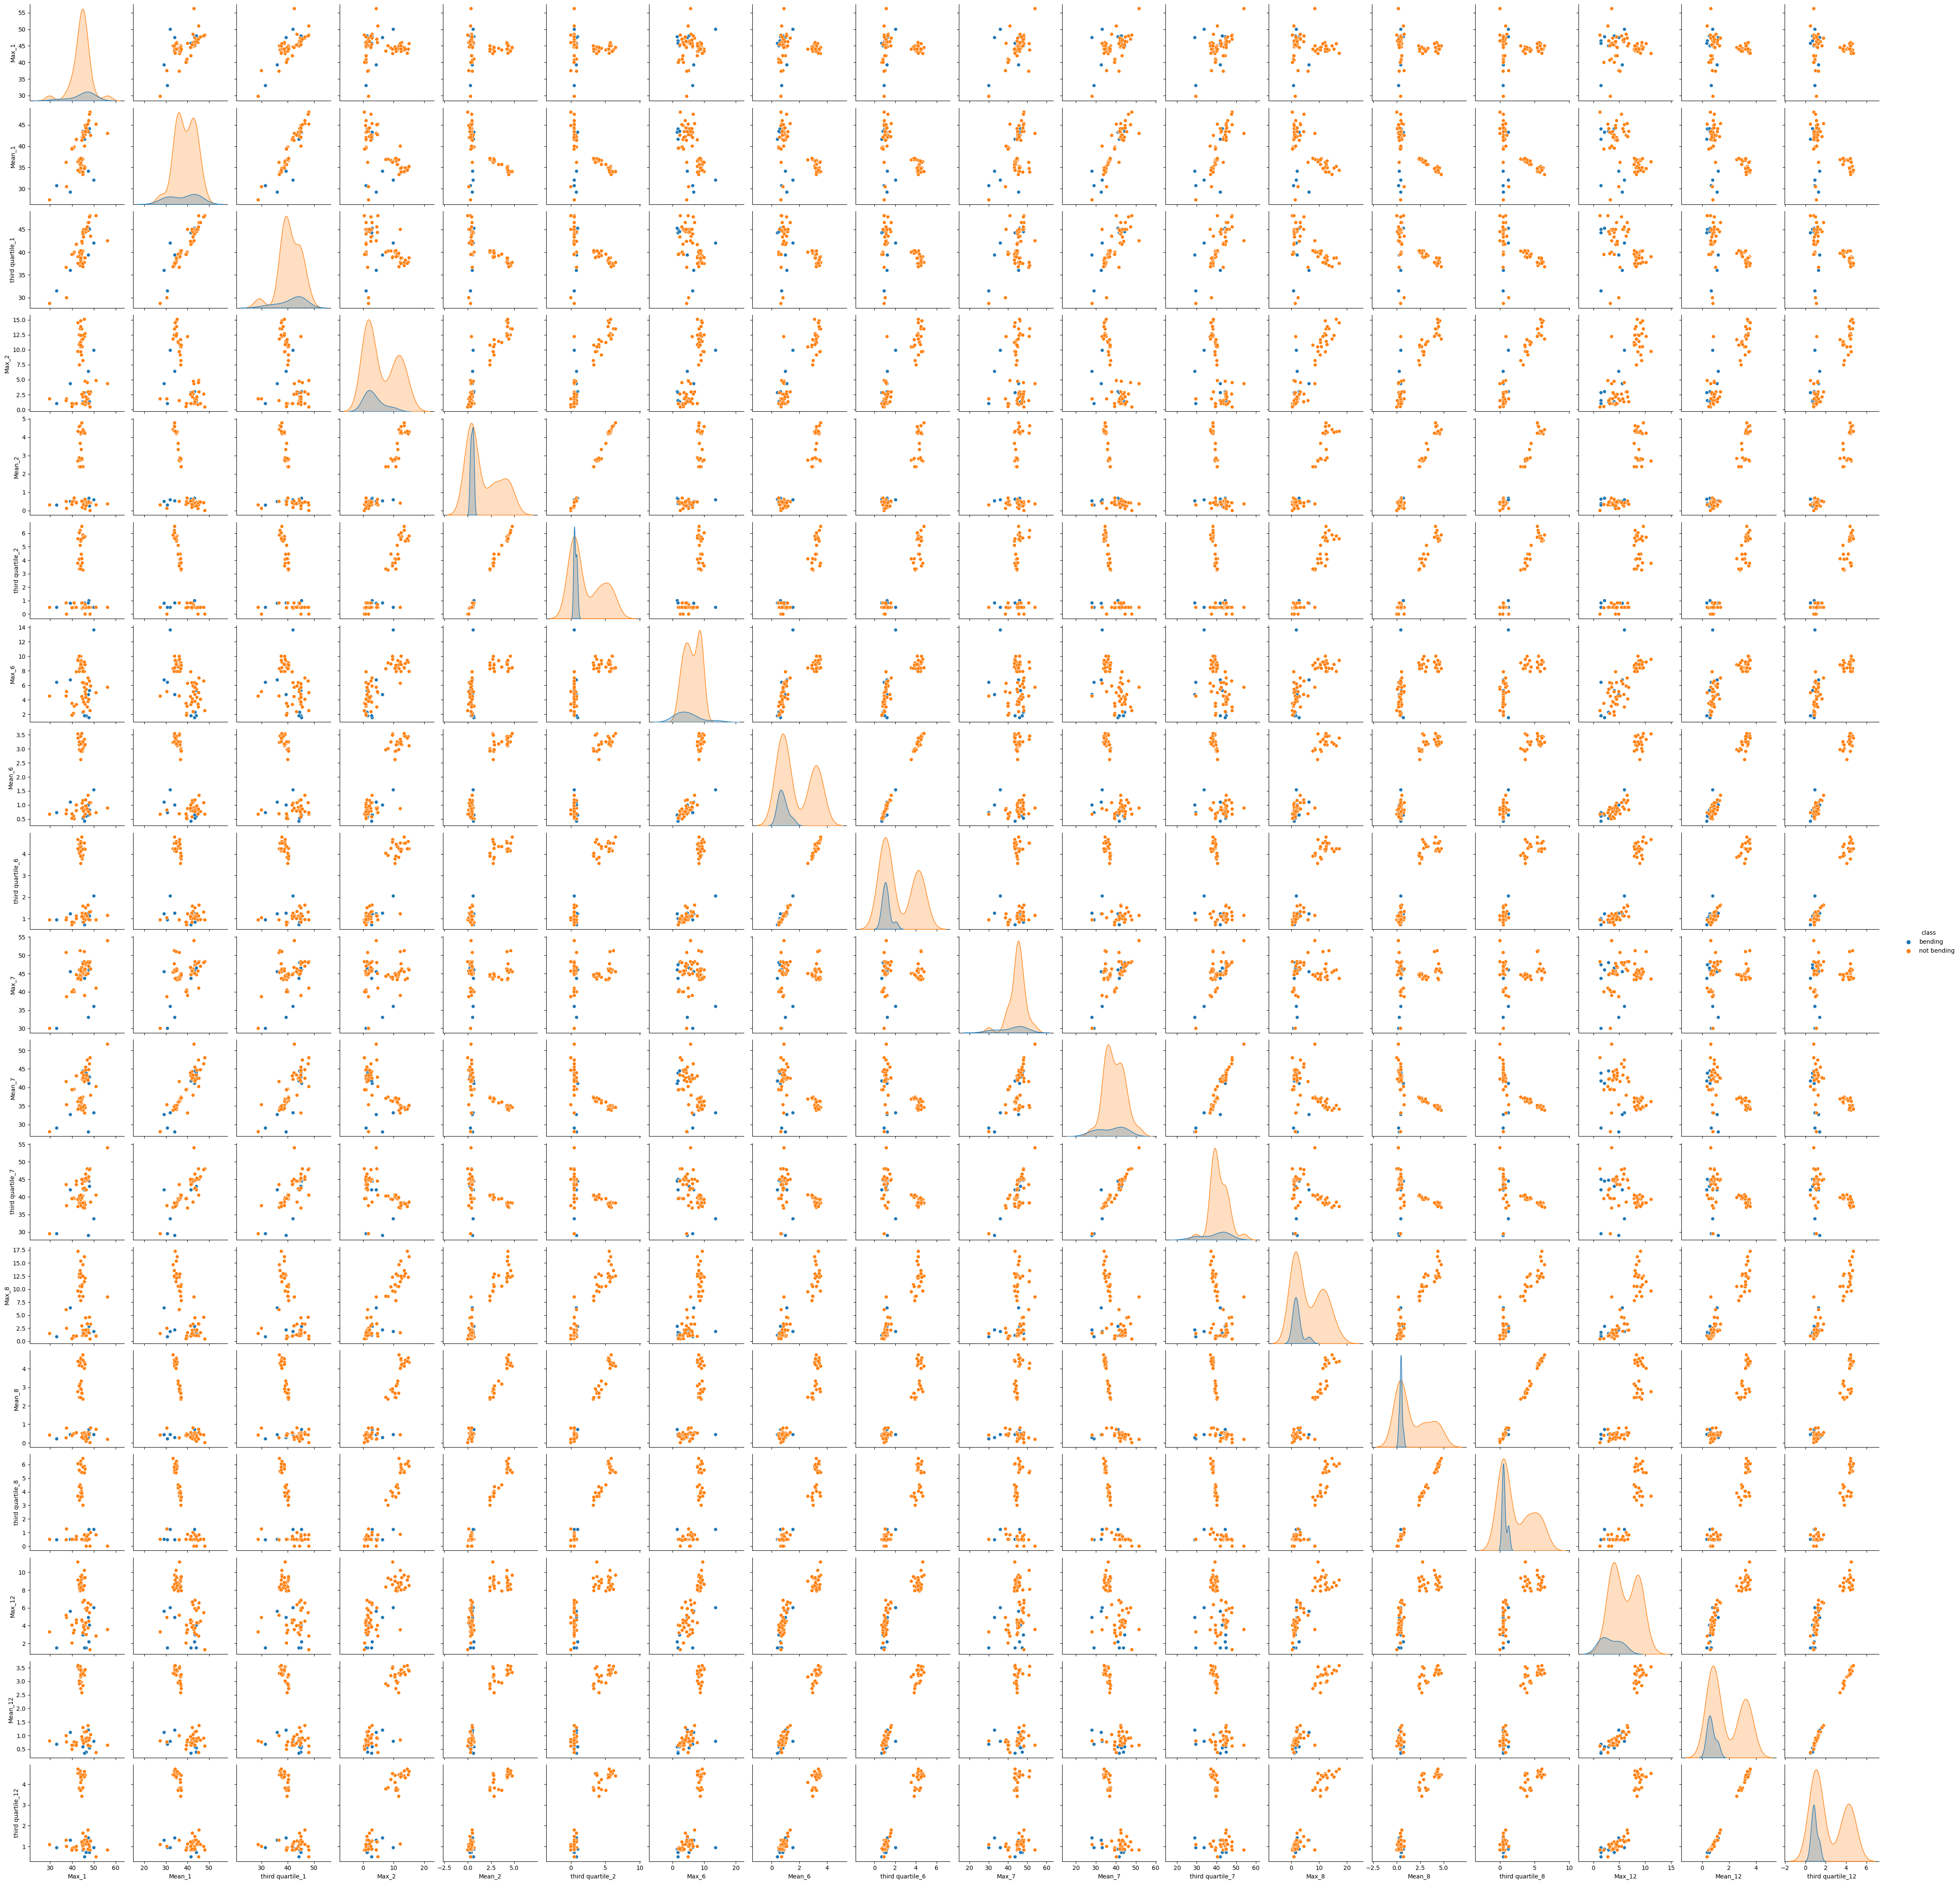

In [38]:
break_2= read_and_transform_dataset(train_files,2)
break_2
break_and_pairplot(break_2, ["Max","Mean","third quartile"],[0,1,5,6,7,11],12)

#### iii. Time Series Segments

In [192]:
def get_features_and_model(X,y,folds=5,slv= 'lbfgs',penalty='l2'):
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1)
    model = LogisticRegression(penalty= penalty, solver=slv, max_iter=180)
    selector = RFECV(estimator=model, cv=kf, scoring='accuracy')
    selector.fit(X, y)
    return model, selector

In [129]:
%%capture --no-stdout

l_p =pd.DataFrame([],columns=["L value","P value","Score"])
for l in range(1,21):
    df_break = read_and_transform_dataset(train_files,l)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    X= df_break.iloc[:,:-1]
    y= df_break.iloc[:,-1]
    y= y.apply(lambda x: np.where('bending' in x , 1 ,0 ))
    model, selector = get_features_and_model(X,y)
    sel_params = selector.n_features_
    acc = selector.cv_results_['mean_test_score'].max()
    l_p.loc[l-1]=np.array([l,sel_params,acc])
    print( f"For L={l} :: {l_p.loc[l-1]}")


For L=1 :: L value    1.000000
P value    3.000000
Score      0.985714
Name: 0, dtype: float64
For L=2 :: L value     2.000000
P value    14.000000
Score       0.971429
Name: 1, dtype: float64
For L=3 :: L value    3.000000
P value    7.000000
Score      0.971429
Name: 2, dtype: float64
For L=4 :: L value    4.000000
P value    5.000000
Score      0.957143
Name: 3, dtype: float64
For L=5 :: L value    5.000000
P value    1.000000
Score      0.957143
Name: 4, dtype: float64
For L=6 :: L value    6.000000
P value    1.000000
Score      0.957143
Name: 5, dtype: float64
For L=7 :: L value    7.000000
P value    1.000000
Score      0.957143
Name: 6, dtype: float64
For L=8 :: L value    8.000000
P value    4.000000
Score      0.928571
Name: 7, dtype: float64
For L=9 :: L value    9.000000
P value    4.000000
Score      0.942857
Name: 8, dtype: float64
For L=10 :: L value    10.000000
P value     1.000000
Score       0.957143
Name: 9, dtype: float64
For L=11 :: L value    11.000000
P value   

In [130]:
l_p

L value  P value     Score
0       1.0      3.0  0.985714
1       2.0     14.0  0.971429
2       3.0      7.0  0.971429
3       4.0      5.0  0.957143
4       5.0      1.0  0.957143
5       6.0      1.0  0.957143
6       7.0      1.0  0.957143
7       8.0      4.0  0.928571
8       9.0      4.0  0.942857
9      10.0      1.0  0.957143
10     11.0      1.0  0.971429
11     12.0      1.0  0.942857
12     13.0      1.0  0.957143
13     14.0      1.0  0.957143
14     15.0      1.0  0.942857
15     16.0      1.0  0.957143
16     17.0      1.0  0.971429
17     18.0      1.0  0.971429
18     19.0      6.0  0.971429
19     20.0      2.0  0.957143

The purpose of cross validation is so that for the various folds we can check how the classifier performs and estimate the error
Hence we should perform Recursive feature elimination along with cross validation which is the correct way. We should not do RFE  before it 

#### iv. Confusion Matrix

In [133]:
train=read_and_transform_dataset(train_files,1)

In [176]:
y_train = train["class"].apply(lambda x: np.where('bending' in x , 1 ,0 ))
lreg_model, selector = get_features_and_model(train.iloc[:,:-1], y_train)


cols = train.columns[:-1]
selected_features=[]
for i in range(len(cols)):
    if selector.support_[i]:
        selected_features.append(cols[i])

print(f"Selected features are {selected_features}")
lreg_model= lreg_model.fit(train[selected_features],y_train)


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Selected features are ['third quartile_1', 'Max_5', 'first quartile_5']


In [137]:
sel_df = train.loc[:, selected_features]
y_train = train.iloc[:,-1].apply(lambda x: np.where('bending' in x , 1 ,0 ))
X = sm.add_constant(sel_df.to_numpy(dtype=float))
sm_model = sm.Logit(y_train.to_numpy(dtype=float), X)
sm_model = sm_model.fit(method='bfgs')
summary = sm_model.summary()
print(summary)



Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       65
Method:                           MLE   Df Model:                            3
Date:                Sat, 04 Mar 2023   Pseudo R-squ.:                   1.000
Time:                        15:47:47   Log-Likelihood:            -1.0778e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 1.481e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8046   1.16e+04     -

(69, 4)


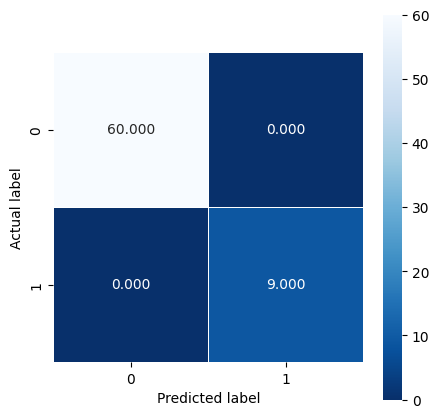

In [145]:
print(X.shape)
pred = sm_model.predict(X)
cm = metrics.confusion_matrix(y_train,np.round(pred))

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');


AUC is :1.0


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


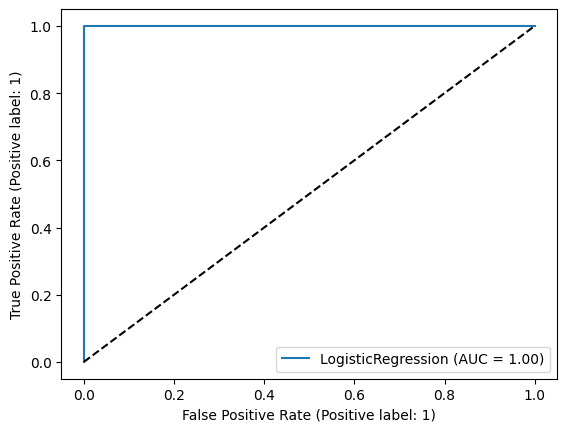

In [146]:
sel_df = train.loc[:, selected_features]
y_train = train.iloc[:,-1].apply(lambda x: np.where('bending' in x , 1 ,0 ))


fpr, tpr, threshold = metrics.roc_curve(y_train, pred)
roc_auc = metrics.auc(fpr, tpr)

lr = LogisticRegression(C=2)
lr.fit(sel_df,y_train)

df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
print(f"AUC is :{roc_auc}")

metrics.plot_roc_curve(lr, sel_df,y_train )
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.show()

#### v. Test Classifier

In [177]:
test=read_and_transform_dataset(test_files,1)
print(selected_features)
x_test = test[ selected_features]
y_test = test.iloc[:,-1].apply(lambda x: np.where('bending' in x , 1 ,0 ))
score=lreg_model.score(x_test,y_test)
print("Test Score is :",score)


['third quartile_1', 'Max_5', 'first quartile_5']
Test Score is : 1.0


Accuracy is similar on test and train set 

#### vi. Separation

The classes are well seperated and this is why we have instability in calculation of parameters.This may also cause parameters to not be identified.

#### vii. Imbalance

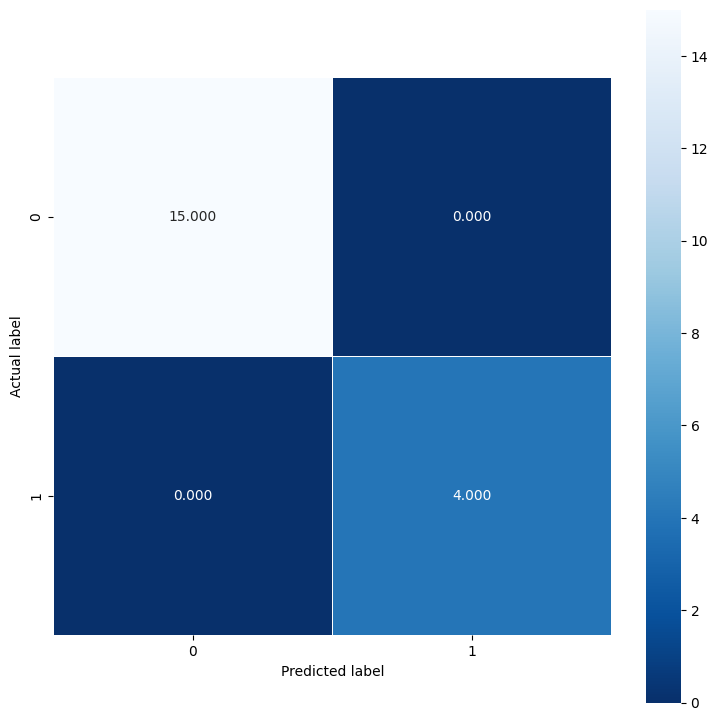

In [178]:
test_pred =lreg_model.predict(x_test)
cm = metrics.confusion_matrix(y_test,test_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

Yes the classes are clearly imbalanced as non bending class samples are much higher 

In [207]:
sel_df = train.loc[:, selected_features]
y_train = train.iloc[:,-1].apply(lambda x: np.where('bending' in x , 1 ,0 ))
y_test = test.iloc[:,-1].apply(lambda x: np.where('bending' in x , 1 ,0 ))


smt = SMOTE(sampling_strategy='all')
over_sampled_train_X, over_sampled_train_y = smt.fit_resample(sel_df, y_train)
print(f"Total samples {len(over_sampled_train_y)} and no of bending : {sum(over_sampled_train_y)}")

Total samples 120 and no of bending : 60


In [208]:
lreg_balance, b_selector = get_features_and_model(over_sampled_train_X,over_sampled_train_y)

cols = over_sampled_train_X.columns
over_selected_features=[]
for i in range(len(cols)):
    if b_selector.support_[i]:
        over_selected_features.append(cols[i])
lreg_balance = lreg_balance.fit(over_sampled_train_X[over_selected_features],over_sampled_train_y)

train_score= lreg_balance.score(over_sampled_train_X[over_selected_features],over_sampled_train_y)
test_score= lreg_balance.score(test[over_selected_features],y_test)
print(f"Train Score :{train_score}   Test Score: {test_score}")

Train Score :1.0   Test Score: 1.0


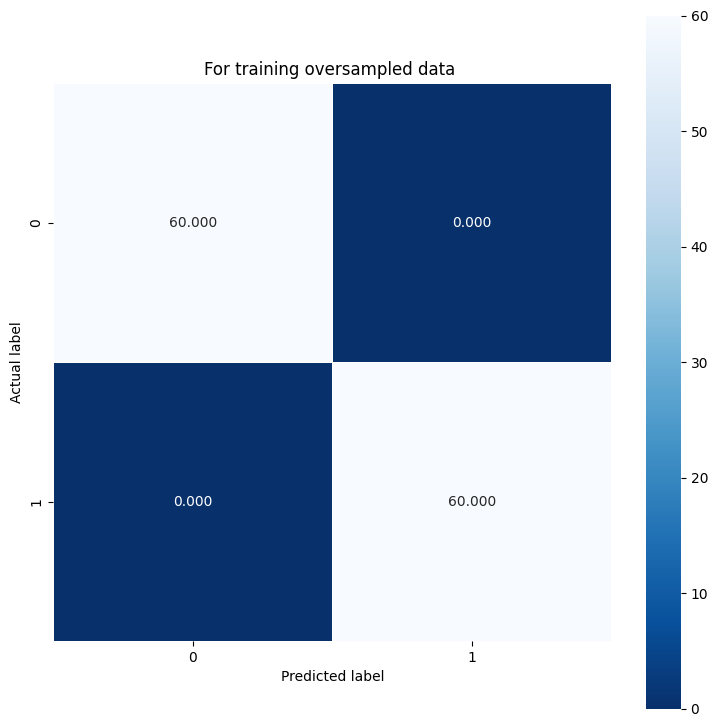

AUC is 1.0


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


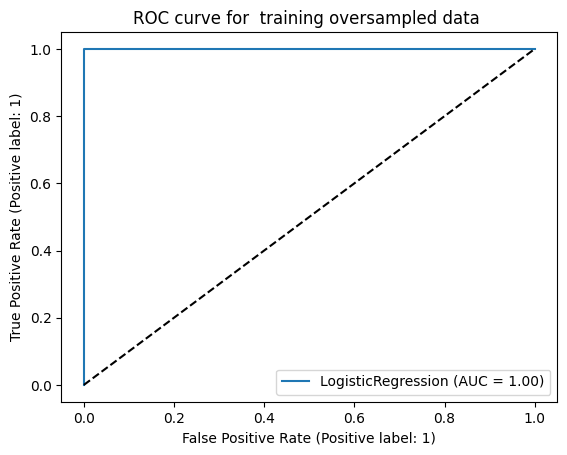

In [216]:
# For training Data 

train_pred =lreg_balance.predict(over_sampled_train_X[over_selected_features])
cm = metrics.confusion_matrix(over_sampled_train_y,train_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("For training oversampled data ")
plt.show()

fpr, tpr, threshold = metrics.roc_curve(over_sampled_train_y, train_pred)
roc_auc = metrics.auc(fpr, tpr)
print(f"AUC is {roc_auc}")

metrics.plot_roc_curve(lreg_balance, over_sampled_train_X,over_sampled_train_y )
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title("ROC curve for  training oversampled data ")
plt.show()

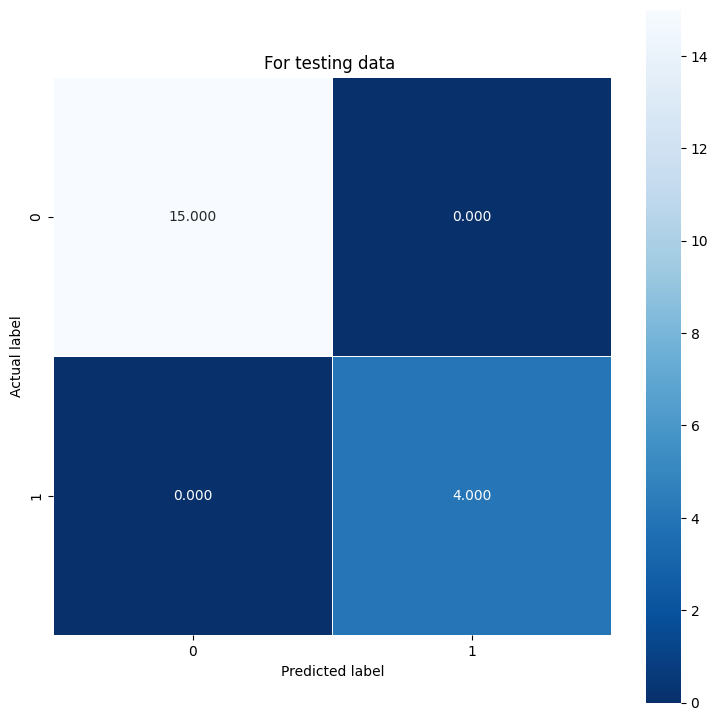

AUC is :1.0


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


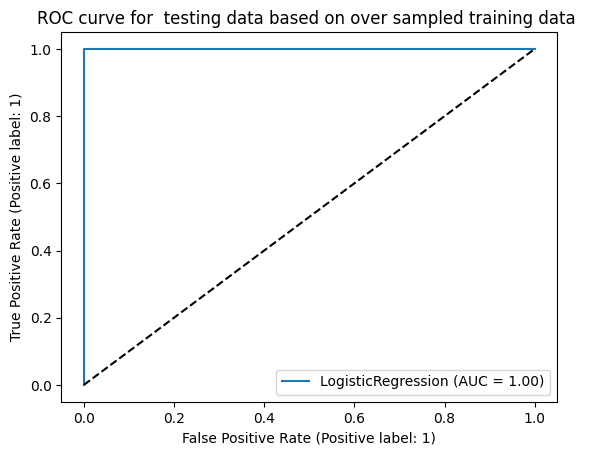

In [217]:
# For testing data

test_pred =lreg_balance.predict(test[over_selected_features])
cm = metrics.confusion_matrix(y_test,test_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("For testing data ")
plt.show()

fpr, tpr, threshold = metrics.roc_curve(y_test, test_pred)
roc_auc = metrics.auc(fpr, tpr)
print(f"AUC is :{roc_auc}")

metrics.plot_roc_curve(lreg_balance, test[over_selected_features],y_test )
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title("ROC curve for  testing data based on over sampled training data ")
plt.show()

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [237]:
l1_acc= pd.DataFrame([],columns=["L value","Train Score ","Test Score"]) 

for l in range(1,21):
    df_break_train = read_and_transform_dataset(train_files,l)
    df_break_test = read_and_transform_dataset(test_files,l)
    X_train = df_break_train.iloc[:,:-1]
    y_train = df_break_train.iloc[:,-1].apply(lambda x: np.where('bending' in x , 1 ,0 ))
    X_test = df_break_test.iloc[:,:-1]
    y_test= df_break_test.iloc[:,-1].apply(lambda x: np.where('bending' in x , 1 ,0 ))
    
    l1_logreg = LogisticRegressionCV(penalty = 'l1',cv=5, random_state=1,scoring='accuracy',max_iter=140 , solver='liblinear')
    l1_logreg= l1_logreg.fit(X_train,y_train)
    
    
    train_score = l1_logreg.score(X_train,y_train)
    test_score = l1_logreg.score(X_test,y_test)
    l1_acc.loc[l-1]= [l,train_score,test_score]
    
best_l= l1_acc['Test Score'].tolist().index(max(l1_acc['Test Score']))
print(f"Best L value is for l ={l1_acc.loc[best_l,'L value']}")
print(l1_acc.iloc[best_l])
l1_acc

Best L value is for l =1.0
L value         1.0
Train Score     1.0
Test Score      1.0
Name: 0, dtype: float64


L value  Train Score   Test Score
0       1.0           1.0    1.000000
1       2.0           1.0    1.000000
2       3.0           1.0    1.000000
3       4.0           1.0    0.947368
4       5.0           1.0    1.000000
5       6.0           1.0    1.000000
6       7.0           1.0    1.000000
7       8.0           1.0    0.947368
8       9.0           1.0    0.947368
9      10.0           1.0    0.947368
10     11.0           1.0    0.947368
11     12.0           1.0    1.000000
12     13.0           1.0    1.000000
13     14.0           1.0    0.947368
14     15.0           1.0    1.000000
15     16.0           1.0    0.947368
16     17.0           1.0    1.000000
17     18.0           1.0    0.947368
18     19.0           1.0    0.947368
19     20.0           1.0    0.947368

AUC is 1.0


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


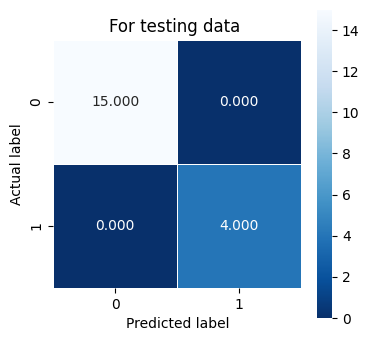

AUC is :1.0


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


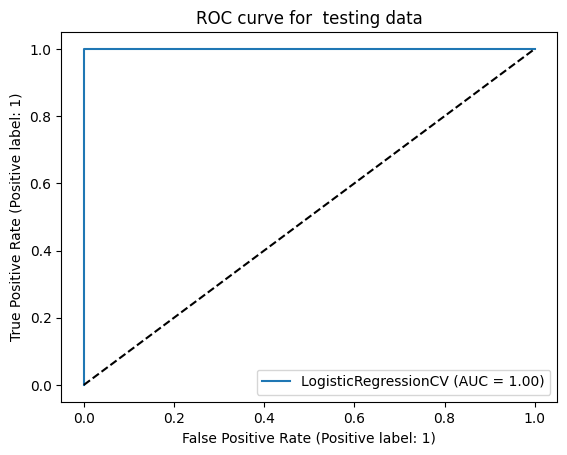

In [241]:
l = l1_acc.loc[best_l,'L value']
df_break_train = read_and_transform_dataset(train_files,int(l))
df_break_test = read_and_transform_dataset(test_files,int(l))
X_train = df_break_train.iloc[:,:-1]
y_train = df_break_train.iloc[:,-1].apply(lambda x: np.where('bending' in x , 1 ,0 ))
X_test = df_break_test.iloc[:,:-1]
y_test= df_break_test.iloc[:,-1].apply(lambda x: np.where('bending' in x , 1 ,0 ))

l1_logreg = LogisticRegressionCV(penalty = 'l1',cv=5, random_state=1,scoring='accuracy',max_iter=140 , solver='liblinear')
l1_logreg= l1_logreg.fit(X_train,y_train)


train_pred =l1_logreg.predict(X_train)
cm = metrics.confusion_matrix(y_train,train_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("For training ")
plt.show()

fpr, tpr, threshold = metrics.roc_curve(y_train, train_pred)
roc_auc = metrics.auc(fpr, tpr)
print(f"AUC is {roc_auc}")

metrics.plot_roc_curve(l1_logreg, X_train ,y_train )
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title("ROC curve for  training data ")
plt.show()




test_pred =l1_logreg.predict(X_test)
cm = metrics.confusion_matrix(y_test,test_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("For testing data ")
plt.show()

fpr, tpr, threshold = metrics.roc_curve(y_test, test_pred)
roc_auc = metrics.auc(fpr, tpr)
print(f"AUC is :{roc_auc}")

metrics.plot_roc_curve(l1_logreg, X_test,y_test )
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title("ROC curve for  testing data")
plt.show()


#### ii. Comparison

L1 logistic performs better than selecting parameters on the test data. The L1 logistic regression is easier to implement as we do not need to pick custom parameters 

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [242]:
l1_acc= pd.DataFrame([],columns=["L value","Train Score ","Test Score"]) 

for l in range(1,21):
    
    df_break_train = read_and_transform_dataset(train_files,l)
    df_break_test = read_and_transform_dataset(test_files,l)
    X_train = df_break_train.iloc[:,:-1]
    y_train = pd.factorize(df_break_train.iloc[:,-1])[0]
    X_test = df_break_test.iloc[:,:-1]
    y_test= pd.factorize(df_break_test.iloc[:,-1])[0]
    
    l1_logreg = LogisticRegressionCV(penalty = 'l1',cv=5, random_state=1,scoring='accuracy',max_iter=140 , solver='liblinear',)
    l1_logreg.fit(X_train,y_train)
    
    
    train_score = l1_logreg.score(X_train,y_train)
    test_score = l1_logreg.score(X_test,y_test)
    l1_acc.loc[l-1]= [l,train_score,test_score]
#     print(f"Running for L = {l}")
#     print(l1_acc.loc[l-1])
    
best_l= l1_acc['Test Score'].tolist().index(max(l1_acc['Test Score']))
print(f"Best L value is for l ={l1_acc.loc[best_l,'L value']}")
print(l1_acc.iloc[best_l])
l1_acc

D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 1
L value         1.000000
Train Score     1.000000
Test Score      0.894737
Name: 0, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 2
L value         2.000000
Train Score     1.000000
Test Score      0.684211
Name: 1, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 3
L value         3.000000
Train Score     1.000000
Test Score      0.736842
Name: 2, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 4
L value         4.000000
Train Score     1.000000
Test Score      0.736842
Name: 3, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 5
L value         5.000000
Train Score     1.000000
Test Score      0.789474
Name: 4, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 6
L value         6.000000
Train Score     1.000000
Test Score      0.736842
Name: 5, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 7
L value         7.000000
Train Score     1.000000
Test Score      0.736842
Name: 6, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 8
L value         8.000000
Train Score     0.971014
Test Score      0.684211
Name: 7, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 9
L value         9.000000
Train Score     1.000000
Test Score      0.789474
Name: 8, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 10
L value         10.000000
Train Score      1.000000
Test Score       0.736842
Name: 9, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 11
L value         11.000000
Train Score      1.000000
Test Score       0.789474
Name: 10, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 12
L value         12.000000
Train Score      1.000000
Test Score       0.789474
Name: 11, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 13
L value         13.000000
Train Score      1.000000
Test Score       0.789474
Name: 12, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 14
L value         14.000000
Train Score      1.000000
Test Score       0.684211
Name: 13, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 15
L value         15.000000
Train Score      0.971014
Test Score       0.736842
Name: 14, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 16
L value         16.000000
Train Score      0.971014
Test Score       0.736842
Name: 15, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 17
L value         17.000000
Train Score      0.971014
Test Score       0.684211
Name: 16, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 18
L value         18.000000
Train Score      1.000000
Test Score       0.736842
Name: 17, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 19
L value         19.000000
Train Score      0.971014
Test Score       0.631579
Name: 18, dtype: float64


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Running for L = 20
L value         20.000000
Train Score      1.000000
Test Score       0.789474
Name: 19, dtype: float64
Best L value is for l =1.0
L value         1.000000
Train Score     1.000000
Test Score      0.894737
Name: 0, dtype: float64


L value  Train Score   Test Score
0       1.0      1.000000    0.894737
1       2.0      1.000000    0.684211
2       3.0      1.000000    0.736842
3       4.0      1.000000    0.736842
4       5.0      1.000000    0.789474
5       6.0      1.000000    0.736842
6       7.0      1.000000    0.736842
7       8.0      0.971014    0.684211
8       9.0      1.000000    0.789474
9      10.0      1.000000    0.736842
10     11.0      1.000000    0.789474
11     12.0      1.000000    0.789474
12     13.0      1.000000    0.789474
13     14.0      1.000000    0.684211
14     15.0      0.971014    0.736842
15     16.0      0.971014    0.736842
16     17.0      0.971014    0.684211
17     18.0      1.000000    0.736842
18     19.0      0.971014    0.631579
19     20.0      1.000000    0.789474

In [316]:
def multi_roc_plots(model, X_test ,y_test,txt="ROC AUC curve"):
    test_pred_prob =model.predict_proba(X_test)
    for i, cls in enumerate(model.classes_):
        y_prob = test_pred_prob[:,i]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=cls)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve for class {cls}')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(txt)
    plt.legend(loc="lower right")
    plt.show()
    


L value : 1.0


D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\AnacondaProjects\envs\python_38_ML\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\AnacondaProjects\envs\pyth

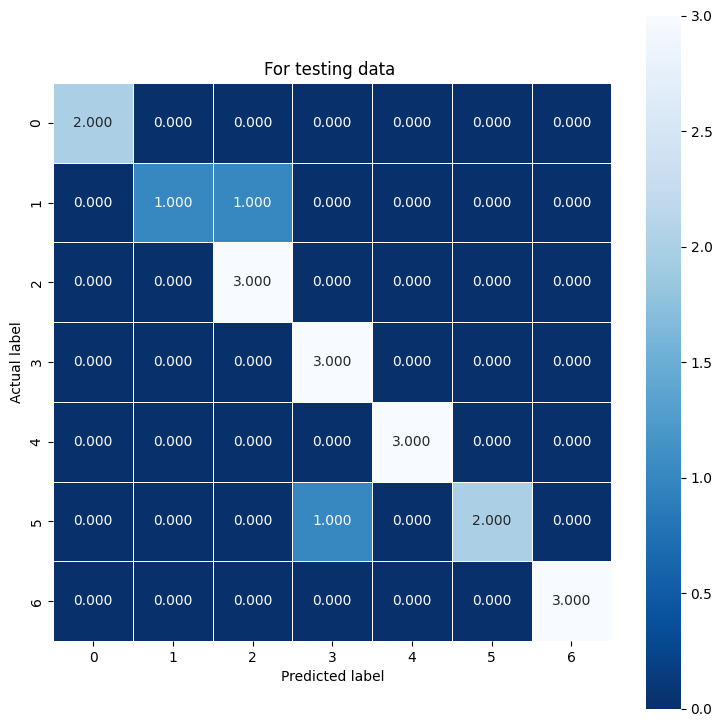

In [317]:
l = l1_acc.loc[best_l,'L value']
print("L value :",l)
df_break_train = read_and_transform_dataset(train_files,int(l))
df_break_test = read_and_transform_dataset(test_files,int(l))
X_train = df_break_train.iloc[:,:-1]
y_train = pd.factorize(df_break_train.iloc[:,-1])[0]
X_test = df_break_test.iloc[:,:-1]
y_test= pd.factorize(df_break_test.iloc[:,-1])[0]



l1_logreg = LogisticRegressionCV(penalty = 'l1',cv=5, random_state=1,max_iter=140,solver='saga' ,multi_class='multinomial')
l1_logreg.fit(X_train,y_train)
test_pred =l1_logreg.predict(X_test)
cm = metrics.confusion_matrix(y_test,test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("For testing data ")
plt.show()

multi_roc_plots(l1_logreg,X_test ,y_test)

#### ii. Naive Bayes

In [318]:
l1_multi_nb_acc= pd.DataFrame([],columns=["L value for multinomial naive bayes","Train Score ","Test Score"]) 

for l in range(1,21):
    
    df_break_train = read_and_transform_dataset(train_files,l)
    df_break_test = read_and_transform_dataset(test_files,l)
    X_train = df_break_train.iloc[:,:-1]
    y_train = pd.factorize(df_break_train.iloc[:,-1])[0]
    X_test = df_break_test.iloc[:,:-1]
    y_test= pd.factorize(df_break_test.iloc[:,-1])[0]
    
    l1_nb = MultinomialNB()
    l1_nb.fit(X_train,y_train)
    
    
    train_score = l1_nb.score(X_train,y_train)
    test_score = l1_nb.score(X_test,y_test)
    l1_multi_nb_acc.loc[l-1]= [l,train_score,test_score]

    
best_l= l1_multi_nb_acc['Test Score'].tolist().index(max(l1_multi_nb_acc.loc[:,'Test Score']))
print(f"Best L value is for l ={l1_multi_nb_acc.loc[best_l,'L value for multinomial naive bayes']}")
print(l1_multi_nb_acc.iloc[best_l])
l1_multi_nb_acc

Best L value is for l =1.0
L value for multinomial naive bayes    1.000000
Train Score                            0.927536
Test Score                             0.894737
Name: 0, dtype: float64


L value for multinomial naive bayes  Train Score   Test Score
0                                   1.0      0.927536    0.894737
1                                   2.0      0.884058    0.736842
2                                   3.0      0.898551    0.789474
3                                   4.0      0.913043    0.789474
4                                   5.0      0.927536    0.736842
5                                   6.0      0.956522    0.736842
6                                   7.0      0.942029    0.736842
7                                   8.0      0.942029    0.736842
8                                   9.0      0.942029    0.736842
9                                  10.0      0.942029    0.736842
10                                 11.0      0.942029    0.736842
11                                 12.0      0.942029    0.736842
12                                 13.0      0.942029    0.789474
13                                 14.0      0.942029    0.789474
14                                 15.0      0.942029    0.789474
15                                 16.0      0.942029    0.789474
16                                 17.0      0.942029    0.842105
17                                 18.0      0.942029    0.842105
18                                 19.0      0.942029    0.842105
19                                 20.0      0.942029    0.842105

L value : 1.0


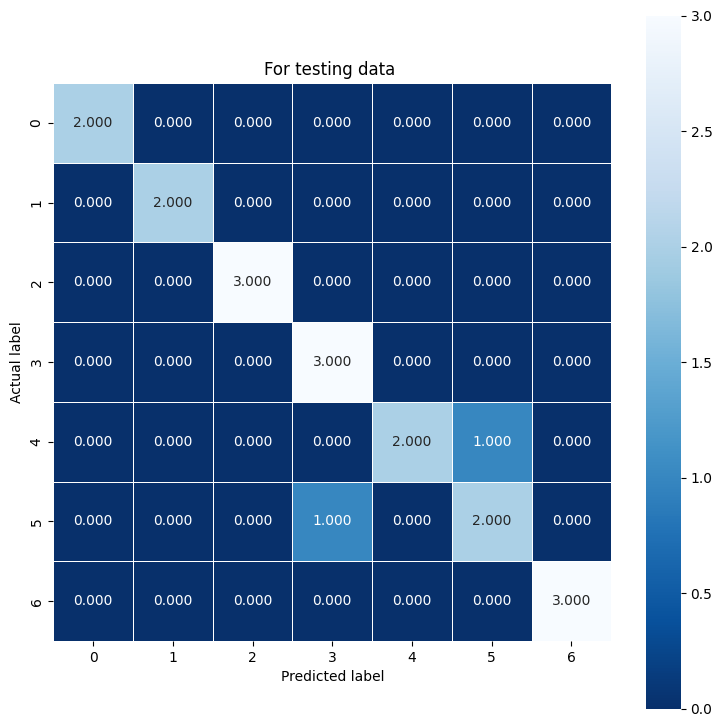

In [323]:
l = l1_multi_nb_acc.loc[best_l,'L value for multinomial naive bayes']
print("L value :",l)
df_break_train = read_and_transform_dataset(train_files,int(l))
df_break_test = read_and_transform_dataset(test_files,int(l))
X_train = df_break_train.iloc[:,:-1]
y_train = pd.factorize(df_break_train.iloc[:,-1])[0]
X_test = df_break_test.iloc[:,:-1]
y_test= pd.factorize(df_break_test.iloc[:,-1])[0]



multi_nb_model = MultinomialNB()
multi_nb_model.fit(X_train,y_train)
test_pred =multi_nb_model.predict(X_test)
cm = metrics.confusion_matrix(y_test,test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("For testing data ")
plt.show()

multi_roc_plots(multi_nb_model,X_test ,y_test)

In [321]:
l1_gauss_nb_acc= pd.DataFrame([],columns=["L value for gaussian naive bayes","Train Score ","Test Score"]) 

for l in range(1,21):
    
    df_break_train = read_and_transform_dataset(train_files,l)
    df_break_test = read_and_transform_dataset(test_files,l)
    X_train = df_break_train.iloc[:,:-1]
    y_train = pd.factorize(df_break_train.iloc[:,-1])[0]
    X_test = df_break_test.iloc[:,:-1]
    y_test= pd.factorize(df_break_test.iloc[:,-1])[0]
    
    l1_nb = GaussianNB()
    l1_nb.fit(X_train,y_train)
    
    
    train_score = l1_nb.score(X_train,y_train)
    test_score = l1_nb.score(X_test,y_test)
    l1_gauss_nb_acc.loc[l-1]= [l,train_score,test_score]
#     print(f"Running for L = {l}")
#     print(l1_acc.loc[l-1])
    
best_l= l1_gauss_nb_acc['Test Score'].tolist().index(max(l1_gauss_nb_acc['Test Score']))
print(f"Best L value is for l ={l1_gauss_nb_acc.loc[best_l,'L value for gaussian naive bayes']}")
print(l1_gauss_nb_acc.iloc[best_l])
l1_gauss_nb_acc

Best L value is for l =1.0
L value for gaussian naive bayes    1.000000
Train Score                         1.000000
Test Score                          0.894737
Name: 0, dtype: float64


L value for gaussian naive bayes  Train Score   Test Score
0                                1.0      1.000000    0.894737
1                                2.0      1.000000    0.631579
2                                3.0      0.985507    0.736842
3                                4.0      1.000000    0.789474
4                                5.0      0.985507    0.789474
5                                6.0      0.971014    0.631579
6                                7.0      1.000000    0.736842
7                                8.0      0.985507    0.736842
8                                9.0      1.000000    0.684211
9                               10.0      1.000000    0.789474
10                              11.0      0.985507    0.684211
11                              12.0      1.000000    0.631579
12                              13.0      1.000000    0.736842
13                              14.0      1.000000    0.578947
14                              15.0      1.000000    0.578947
15                              16.0      1.000000    0.526316
16                              17.0      1.000000    0.526316
17                              18.0      1.000000    0.684211
18                              19.0      1.000000    0.473684
19                              20.0      1.000000    0.578947

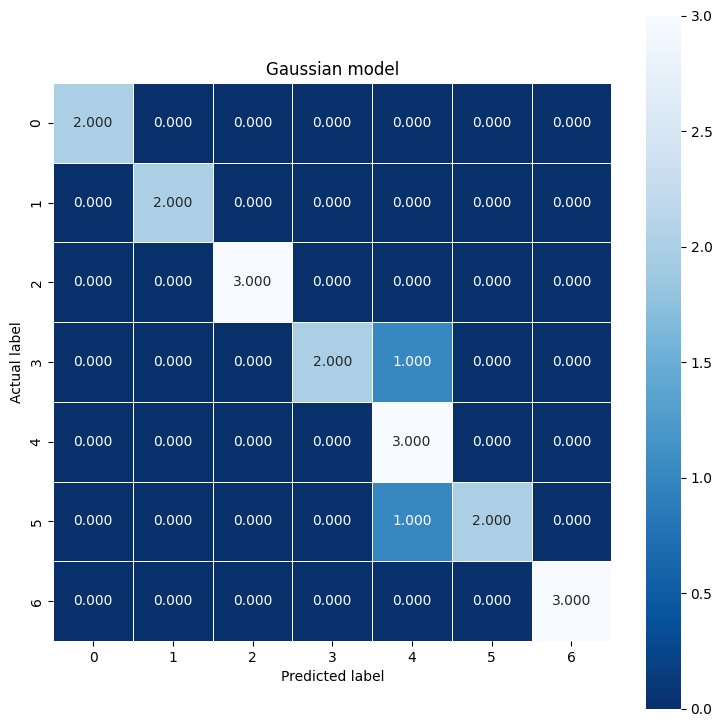

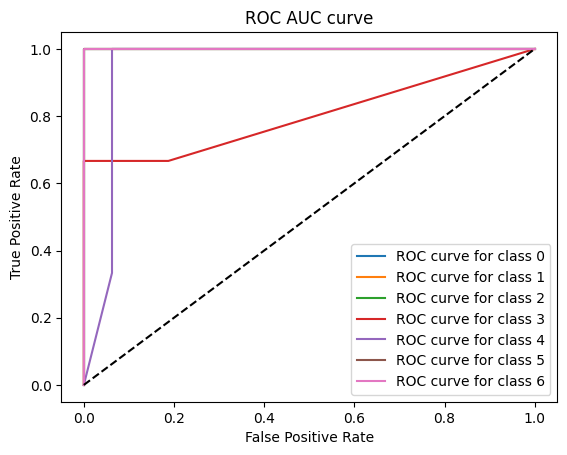

In [326]:
l = l1_gauss_nb_acc.loc[best_l,'L value for gaussian naive bayes']
df_break_train = read_and_transform_dataset(train_files,int(l))
df_break_test = read_and_transform_dataset(test_files,int(l))
X_train = df_break_train.iloc[:,:-1]
y_train = pd.factorize(df_break_train.iloc[:,-1])[0]
X_test = df_break_test.iloc[:,:-1]
y_test= pd.factorize(df_break_test.iloc[:,-1])[0]

gauss_nb = GaussianNB()
gauss_nb.fit(X_train,y_train)

test_pred =gauss_nb.predict(X_test)
cm = metrics.confusion_matrix(y_test,test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Gaussian model")
plt.show()

multi_roc_plots(gauss_nb,X_test ,y_test)

#### ii. Comparison

The area under the ROC curve (AUC) gives best results for logistic regression and hence logistic regression performs the best among them 

## 3. ISLR 4.8.3

<img src=".././data/4.8.3.jpeg" alt="Alternative text" />

## 4. ISLR 4.8.7

<img src=".././data/4.8.3.jpeg" alt="Alternative text" />
<img src=".././data/4.8.7_2.jpeg" alt="Alternative text" />

## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9